## Weather Prediction:  A comparision of traditional and modern methods

In this study, we are going to use Python and Machine Learning to build models to predict weather temperatures based off data from WorldWeatherOnline. There are three "phases" to this study:

1. Data collection and processing (i.e. like doing an experiment!)
2. Using Linear Regression models (i.e. a traditional fitting approach)
3. Using Neural Network models (i.e. a machine-learning approach)

The data used will be collected from the WorldWeatherOnline API web services. We will interact with the API to pull in weather data over a given time period, for a given location.

Once collected, the data will need to be processed and aggregated into a format that is suitable for data analysis, and then cleaned.

In [1]:
# import the usual libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

# We are going to need several additional libraries.  We import them here, but
# I will discuss their purpose and give further details as they are used.

In [2]:
import os
os.chdir("/home/brash/Phys421/WWO")
df = pd.read_csv('regina.csv')

In [3]:
df.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2019-01-01 00:00:00,-12,-26,0.0,5.0,2,26,04:26 AM,02:31 PM,08:59 AM,...,18,1,73,0.0,1037,-28,10,203,10,regina
1,2019-01-01 03:00:00,-12,-26,0.0,5.0,2,26,04:26 AM,02:31 PM,08:59 AM,...,24,0,76,0.0,1036,-28,10,184,12,regina
2,2019-01-01 06:00:00,-12,-26,0.0,5.0,2,26,04:26 AM,02:31 PM,08:59 AM,...,30,2,75,0.0,1034,-27,10,172,14,regina
3,2019-01-01 09:00:00,-12,-26,0.0,5.0,2,26,04:26 AM,02:31 PM,08:59 AM,...,36,18,73,0.0,1030,-24,10,177,16,regina
4,2019-01-01 12:00:00,-12,-26,0.0,5.0,2,26,04:26 AM,02:31 PM,08:59 AM,...,35,68,69,0.0,1025,-18,10,192,18,regina


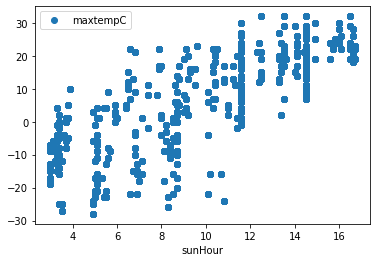

In [4]:
df.plot('sunHour','maxtempC',style='o')

In [5]:
df.describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000
mean,6.320548,-1.304110,0.096986,9.662740,2.778082,45.084932,-2.838014,-0.770548,2.878082,-0.827740,23.602055,52.373973,70.643151,0.245616,1016.797603,2.400000,9.358219,208.951370,15.385959
std,15.216829,13.729361,0.388413,4.160689,1.682609,31.265919,12.333195,17.486786,14.668713,17.401909,9.792916,35.089030,18.465102,1.122934,9.612167,14.716189,3.195969,94.130181,6.751093
min,-28.000000,-36.000000,0.000000,3.000000,1.000000,0.000000,-40.000000,-46.000000,-36.000000,-46.000000,2.000000,0.000000,17.000000,0.000000,992.000000,-37.000000,0.000000,1.000000,1.000000
25%,-6.000000,-12.000000,0.000000,5.900000,1.000000,17.000000,-10.000000,-14.000000,-8.000000,-14.000000,17.000000,18.000000,58.000000,0.000000,1010.000000,-9.000000,9.000000,130.000000,10.000000
50%,8.000000,1.000000,0.000000,9.200000,2.000000,44.000000,-2.000000,1.000000,4.000000,1.000000,23.000000,50.000000,74.000000,0.000000,1016.000000,4.000000,10.000000,217.000000,14.000000
75%,20.000000,11.000000,0.000000,13.500000,4.000000,72.000000,7.000000,14.000000,15.000000,14.000000,30.000000,87.000000,86.000000,0.000000,1023.000000,15.000000,10.000000,297.000000,19.000000
max,32.000000,21.000000,3.400000,16.700000,7.000000,100.000000,19.000000,33.000000,33.000000,31.000000,61.000000,100.000000,100.000000,33.400000,1048.000000,31.000000,20.000000,358.000000,46.000000


In [6]:
# Create new feature columns ... the idea is that we are going to
# try to predict the temperature for tomorrow by looking at what
# happened today, and for the past three days.

# For each feature that we think might be an important factor in
# determining out temperature forecast, we will add a column to the
# dataframe for this variable for each of the previous three days.
#
# The factor 8*N takes into account that the data in our dataframe
# is reported once every three hours (or 8 times per day)

def derive_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_measurements = [None]*8*N + [df[feature][i-8*N] for i in range(8*N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements

In [7]:
# These are the features/variables that we think a priori might be
# important in our forecasting model

features = ["date_time", "tempC", "DewPointC","pressure","humidity",
            "maxtempC", "mintempC", "sunHour", "windspeedKmph",
            "winddirDegree","precipMM"]


In [8]:
# Now, for each of these features, add three new columns to the
# dataframe which correspond to yesterday, the day before yesterday,
# and the day before that.  The column names will be the same as
# the name as the original feature, but with _1, _2, or _3 added on.

for feature in features:
    if feature != 'date_time':
        for N in range(1, 4):
            derive_nth_day_feature(df, feature, N)

In [9]:
# We see now that we have accomplished our task ... a lot of new
# columns have been added!

df.columns
df.describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,...,sunHour_3,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,...,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000
mean,6.320548,-1.304110,0.096986,9.662740,2.778082,45.084932,-2.838014,-0.770548,2.878082,-0.827740,...,9.672928,15.394574,15.407369,15.426796,208.945398,208.695592,208.353591,0.246291,0.246970,0.247652
std,15.216829,13.729361,0.388413,4.160689,1.682609,31.265919,12.333195,17.486786,14.668713,17.401909,...,4.176386,6.757152,6.760687,6.759334,94.242035,94.249179,94.153133,1.124402,1.125876,1.127356
min,-28.000000,-36.000000,0.000000,3.000000,1.000000,0.000000,-40.000000,-46.000000,-36.000000,-46.000000,...,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,-6.000000,-12.000000,0.000000,5.900000,1.000000,17.000000,-10.000000,-14.000000,-8.000000,-14.000000,...,5.900000,10.000000,10.000000,10.000000,130.000000,129.000000,129.000000,0.000000,0.000000,0.000000
50%,8.000000,1.000000,0.000000,9.200000,2.000000,44.000000,-2.000000,1.000000,4.000000,1.000000,...,9.300000,14.000000,14.000000,14.000000,217.000000,216.500000,216.000000,0.000000,0.000000,0.000000
75%,20.000000,11.000000,0.000000,13.500000,4.000000,72.000000,7.000000,14.000000,15.000000,14.000000,...,13.500000,19.000000,19.000000,19.000000,297.000000,297.000000,296.000000,0.000000,0.000000,0.000000
max,32.000000,21.000000,3.400000,16.700000,7.000000,100.000000,19.000000,33.000000,33.000000,31.000000,...,16.700000,46.000000,46.000000,46.000000,358.000000,358.000000,358.000000,33.400000,33.400000,33.400000


In [10]:
# We now want to clean up the dataframe, and get rid of columns that
# we are not interested in.  This is not so important in this example,
# but if we are dealing with large dataframes with thousands of columns
# of data, it can really speed things up by condensing things.

# make list of original features we are not interested in
to_remove = [feature 
             for feature in features 
             if feature not in ['date_time','maxtempC', 'mintempC', 'tempC']]
for col in ['DewPointC','pressure','humidity','sunHour',
                'windspeedKmph','winddirDegree','precipMM',
                 'totalSnow_cm','uvIndex','moon_illumination',
                  'moonrise','moonset','sunrise','sunset','FeelsLikeC',
                 'HeatIndexC','WindChillC','WindGustKmph','cloudcover',
                 'visibility','location']:
    to_remove.append(col)

print(to_remove)

# make a list of columns to keep
to_keep = [col for col in df.columns if col not in to_remove]

print(to_keep)

# select only the columns in to_keep and assign to df
df = df[to_keep]
df.columns

['DewPointC', 'pressure', 'humidity', 'sunHour', 'windspeedKmph', 'winddirDegree', 'precipMM', 'DewPointC', 'pressure', 'humidity', 'sunHour', 'windspeedKmph', 'winddirDegree', 'precipMM', 'totalSnow_cm', 'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise', 'sunset', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'visibility', 'location']
['date_time', 'maxtempC', 'mintempC', 'tempC', 'tempC_1', 'tempC_2', 'tempC_3', 'DewPointC_1', 'DewPointC_2', 'DewPointC_3', 'pressure_1', 'pressure_2', 'pressure_3', 'humidity_1', 'humidity_2', 'humidity_3', 'maxtempC_1', 'maxtempC_2', 'maxtempC_3', 'mintempC_1', 'mintempC_2', 'mintempC_3', 'sunHour_1', 'sunHour_2', 'sunHour_3', 'windspeedKmph_1', 'windspeedKmph_2', 'windspeedKmph_3', 'winddirDegree_1', 'winddirDegree_2', 'winddirDegree_3', 'precipMM_1', 'precipMM_2', 'precipMM_3']


Index(['date_time', 'maxtempC', 'mintempC', 'tempC', 'tempC_1', 'tempC_2',
       'tempC_3', 'DewPointC_1', 'DewPointC_2', 'DewPointC_3', 'pressure_1',
       'pressure_2', 'pressure_3', 'humidity_1', 'humidity_2', 'humidity_3',
       'maxtempC_1', 'maxtempC_2', 'maxtempC_3', 'mintempC_1', 'mintempC_2',
       'mintempC_3', 'sunHour_1', 'sunHour_2', 'sunHour_3', 'windspeedKmph_1',
       'windspeedKmph_2', 'windspeedKmph_3', 'winddirDegree_1',
       'winddirDegree_2', 'winddirDegree_3', 'precipMM_1', 'precipMM_2',
       'precipMM_3'],
      dtype='object')

In [11]:
# If we look at the dataframe now, we see that we have just the
# columns that we are interested in.  All of the columns are either
# integers or floats, and so we don't need to do anything else.

# However, we also notice that for some columns, we are missing a few
# data points.  The reason for this is simple:  If we are looking back
# several days, the first entry in the column for a particular variable
# is not going to have any data associated with it for previous days,
# the second entry in a column will only have data for the previous day,
# etc.  We can handle this by droping rows that do not have complete data!

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date_time        2920 non-null   object 
 1   maxtempC         2920 non-null   int64  
 2   mintempC         2920 non-null   int64  
 3   tempC            2920 non-null   int64  
 4   tempC_1          2912 non-null   float64
 5   tempC_2          2904 non-null   float64
 6   tempC_3          2896 non-null   float64
 7   DewPointC_1      2912 non-null   float64
 8   DewPointC_2      2904 non-null   float64
 9   DewPointC_3      2896 non-null   float64
 10  pressure_1       2912 non-null   float64
 11  pressure_2       2904 non-null   float64
 12  pressure_3       2896 non-null   float64
 13  humidity_1       2912 non-null   float64
 14  humidity_2       2904 non-null   float64
 15  humidity_3       2896 non-null   float64
 16  maxtempC_1       2912 non-null   float64
 17  maxtempC_2    

In [12]:
# the last task is to convert the date_time column from an object into a floating point number
# there are a number of ways that we could do this

df['date'] = pd.to_datetime(df['date_time'])    
df['date_delta'] = (df['date'] - df['date'].min())  / np.timedelta64(1,'D')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date_time        2920 non-null   object        
 1   maxtempC         2920 non-null   int64         
 2   mintempC         2920 non-null   int64         
 3   tempC            2920 non-null   int64         
 4   tempC_1          2912 non-null   float64       
 5   tempC_2          2904 non-null   float64       
 6   tempC_3          2896 non-null   float64       
 7   DewPointC_1      2912 non-null   float64       
 8   DewPointC_2      2904 non-null   float64       
 9   DewPointC_3      2896 non-null   float64       
 10  pressure_1       2912 non-null   float64       
 11  pressure_2       2904 non-null   float64       
 12  pressure_3       2896 non-null   float64       
 13  humidity_1       2912 non-null   float64       
 14  humidity_2       2904 non-null   float64

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


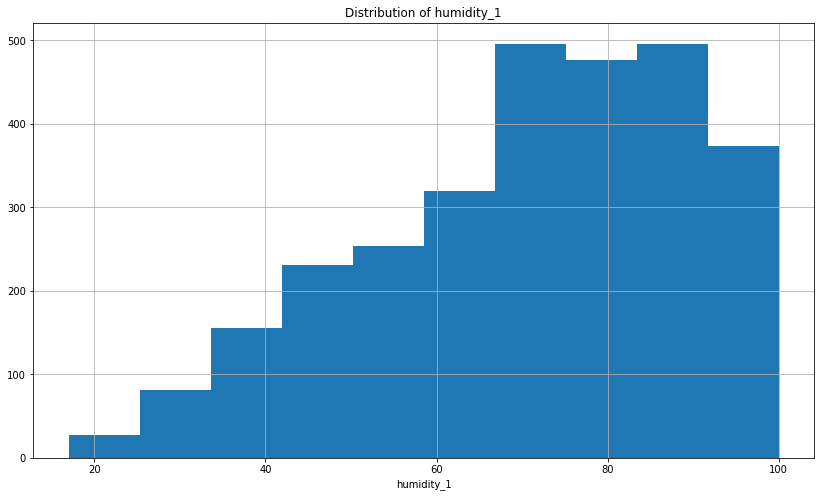

In [13]:
# Let us now look at a few of the columns of data
#
# We see that humidity, for example, is NOT a normal distribution!  We
# should remember that, going forward, as it may end up causing issues.

%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]
df.humidity_1.hist()
plt.title('Distribution of humidity_1')
plt.xlabel('humidity_1')
plt.show()

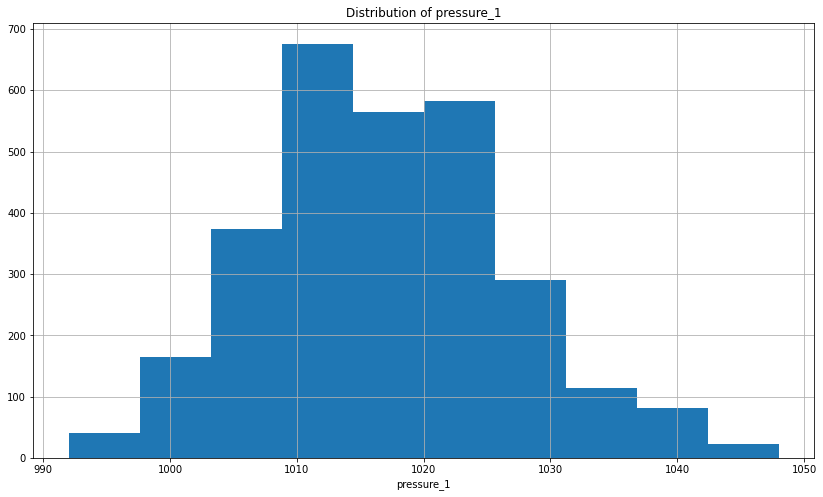

In [14]:
# The pressure, on the other hand, looks like a nice Gaussian distribution.
# We really should look at EVERY column in this manner, and try to determine
# if the distribution is normal, and if there are any bad data points (outliers).

df.pressure_1.hist()
plt.title('Distribution of pressure_1')
plt.xlabel('pressure_1')
plt.show()

In [15]:
df.describe()

,maxtempC,mintempC,tempC,tempC_1,tempC_2,tempC_3,DewPointC_1,DewPointC_2,DewPointC_3,pressure_1,...,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3,date_delta
count,2920.000000,2920.000000,2920.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,...,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000,2912.000000,2904.000000,2896.000000,2920.000000
mean,6.320548,-1.304110,2.400000,2.430632,2.467975,2.509669,-2.818681,-2.792011,-2.763122,1016.820055,...,15.394574,15.407369,15.426796,208.945398,208.695592,208.353591,0.246291,0.246970,0.247652,182.437500
std,15.216829,13.729361,14.716189,14.724260,14.727248,14.726074,12.344175,12.350580,12.355325,9.609942,...,6.757152,6.760687,6.759334,94.242035,94.249179,94.153133,1.124402,1.125876,1.127356,105.384465
min,-28.000000,-36.000000,-37.000000,-37.000000,-37.000000,-37.000000,-40.000000,-40.000000,-40.000000,992.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.000000,-12.000000,-9.000000,-9.000000,-8.000000,-8.000000,-10.000000,-10.000000,-10.000000,1010.000000,...,10.000000,10.000000,10.000000,130.000000,129.000000,129.000000,0.000000,0.000000,0.000000,91.218750
50%,8.000000,1.000000,4.000000,4.000000,4.000000,4.000000,-2.000000,-2.000000,-2.000000,1016.000000,...,14.000000,14.000000,14.000000,217.000000,216.500000,216.000000,0.000000,0.000000,0.000000,182.437500
75%,20.000000,11.000000,15.000000,15.000000,15.000000,15.000000,7.000000,7.000000,7.250000,1023.000000,...,19.000000,19.000000,19.000000,297.000000,297.000000,296.000000,0.000000,0.000000,0.000000,273.656250
max,32.000000,21.000000,31.000000,31.000000,31.000000,31.000000,19.000000,19.000000,19.000000,1048.000000,...,46.000000,46.000000,46.000000,358.000000,358.000000,358.000000,33.400000,33.400000,33.400000,364.875000


In [16]:
# Now, let's get rid of the rows that do not have complete data!

df = df.dropna()

In [17]:
df.describe()

,maxtempC,mintempC,tempC,tempC_1,tempC_2,tempC_3,DewPointC_1,DewPointC_2,DewPointC_3,pressure_1,...,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3,date_delta
count,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.00000,...,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000
mean,6.408840,-1.193370,2.507251,2.521064,2.532804,2.509669,-2.752417,-2.737914,-2.763122,1016.81837,...,15.382942,15.402279,15.426796,208.774862,208.706146,208.353591,0.247583,0.247652,0.247652,183.937500
std,15.240659,13.710701,14.708777,14.700401,14.692271,14.726074,12.325907,12.318514,12.355325,9.60103,...,6.767450,6.764643,6.759334,94.419867,94.365531,94.153133,1.127368,1.127356,1.127356,104.518439
min,-28.000000,-36.000000,-37.000000,-37.000000,-37.000000,-37.000000,-40.000000,-40.000000,-40.000000,992.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,-6.000000,-12.000000,-8.000000,-8.000000,-8.000000,-8.000000,-10.000000,-10.000000,-10.000000,1010.00000,...,10.000000,10.000000,10.000000,129.000000,129.000000,129.000000,0.000000,0.000000,0.000000,93.468750
50%,8.000000,1.000000,4.000000,4.000000,4.000000,4.000000,-2.000000,-2.000000,-2.000000,1016.00000,...,14.000000,14.000000,14.000000,217.000000,217.000000,216.000000,0.000000,0.000000,0.000000,183.937500
75%,20.000000,11.000000,15.000000,15.000000,15.000000,15.000000,7.250000,7.250000,7.250000,1023.00000,...,19.000000,19.000000,19.000000,297.000000,297.000000,296.000000,0.000000,0.000000,0.000000,274.406250
max,32.000000,21.000000,31.000000,31.000000,31.000000,31.000000,19.000000,19.000000,19.000000,1048.00000,...,46.000000,46.000000,46.000000,358.000000,358.000000,358.000000,33.400000,33.400000,33.400000,364.875000


## We are now ready to do a linear regression fit to the data!!

In [18]:
# our first task is to determine what the important variables/features are!
#
# The corr() method of the dataframe object will return the Pearson correlation
# coefficient, r, which measures the amount of correlation between two variables.
#
# Values close to 1 indicate a strong positive correlation; values close to -1
# indicate a strong negative correlation, and values close to zero indicate little
# correlation.  We want to look at the correlation between all of the variables in
# our dataframe with the daily mean temperature (tempC).  We will also sort these 
# values from smallest to largest.
#
# Perhaps not surprisingly, the strongest positive correlations come from looking at
# the temperature in the previous days.  The strongest negative correlations are
# associated with pressure and temperature.  That is, if the pressure is low, 
# the temperatures tend to be a little higher, and vice versa, and if the humidity is low
# the temperatures tend to be a little higher, and vice versa.

df.corr()[['tempC']].sort_values('tempC')

,tempC
pressure_1,-0.555953
humidity_1,-0.490593
pressure_2,-0.489284
pressure_3,-0.476027
humidity_2,-0.473079
humidity_3,-0.463825
winddirDegree_1,-0.099359
winddirDegree_2,-0.082629
winddirDegree_3,-0.074630
windspeedKmph_2,0.080198


In [19]:
# for our model, we will only include variables where the abs(r) > 0.4 - that is, either
# a strong positive or strong negative correlation.

predictors = ['tempC_1',  'DewPointC_1',  'maxtempC_1', 
              'mintempC_1',   'tempC_2',   'DewPointC_2',
              'maxtempC_2', 'mintempC_2', 'tempC_3',
              'DewPointC_3',  'mintempC_3',  'maxtempC_3',
              'pressure_1',  'pressure_2',  'pressure_3',
              'humidity_1',   'humidity_2', 'humidity_3',
              'sunHour_1', 'sunHour_2', 'sunHour_3']
df2 = df[['date_delta']+['tempC'] + predictors]

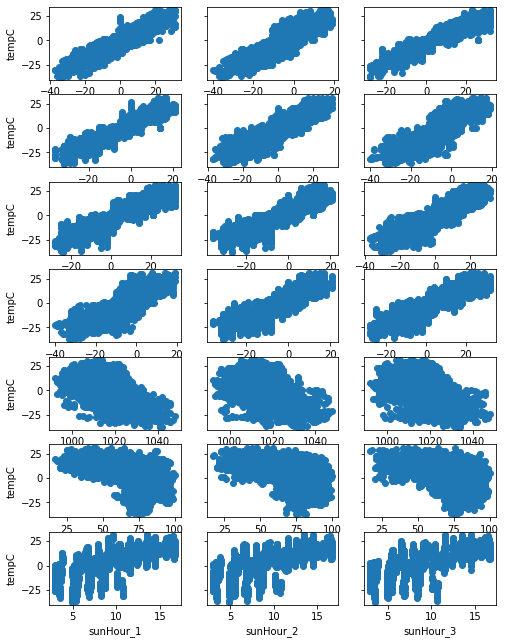

In [20]:
plt.rcParams['figure.figsize'] = [8, 11]
fig, axes = plt.subplots(nrows=7, ncols=3, sharey=True)
arr = np.array(predictors).reshape(7, 3)

for row, col_arr in enumerate(arr):
    for col, feature in enumerate(col_arr):
        axes[row, col].scatter(df2[feature], df2['tempC'])
        if col == 0:
            axes[row, col].set(xlabel=feature, ylabel='tempC')
        else:
            axes[row, col].set(xlabel=feature)
plt.show()

In [21]:
# import the relevant module
import statsmodels.api as sm

# separate our my predictor variables (X) from my outcome variable y
X = df2[predictors+['date_delta']]
y = df2['tempC']

# Add a constant to the predictor variable set to represent the Bo intercept
X = sm.add_constant(X)

In [22]:
# (1) select a significance value
alpha = 0.05

# (2) Fit the model
model = sm.OLS(y, X).fit()

# (3) evaluate the coefficients' p-values
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tempC   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     1836.
Date:                Fri, 02 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:07:46   Log-Likelihood:                -7967.2
No. Observations:                2896   AIC:                         1.598e+04
Df Residuals:                    2873   BIC:                         1.612e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -140.2663     13.751    -10.201      0.000    -167.229    -113.304
tempC_1         0.0088      0.049      0.178      0.859      -0.088       0.106
DewPointC_1     0.5635      0.056     10.075      0.000       0.454       0.673
maxtempC_1      0.4490      0.031     14.602      0.000       0.389       0.509
mintempC_1      0.0654      0.035      1.873      0.061      -0.003       0.134
tempC_2         0.1591      0.050      3.186      0.001       0.061       0.257
DewPointC_2    -0.1163      0.058     -1.992      0.047      -0.231      -0.002
maxtempC_2     -0.2760      0.033     -8.296      0.000      -0.341      -0.211
mintempC_2     -0.0162      0.035     -0.458      0.647      -0.086       0.053
tempC_3         0.2215      0.049      4.541      0.000       0.126       0.317
DewPointC_3     0.0411      0.055      0.744      0.457      -0.067       0.150
mintempC_3     -0.1159      0.032     -3.570      0.000      -0.180      -0.052
maxtempC_3     -0.0065      0.032     -0.200      0.842      -0.070       0.057
pressure_1      0.1490      0.014     10.931      0.000       0.122       0.176
pressure_2     -0.0292      0.017     -1.766      0.077      -0.062       0.003
pressure_3      0.0245      0.014      1.759      0.079      -0.003       0.052
humidity_1     -0.1048      0.014     -7.577      0.000      -0.132      -0.078
humidity_2      0.0140      0.014      0.990      0.322      -0.014       0.042
humidity_3     -0.0276      0.014     -2.026      0.043      -0.054      -0.001
sunHour_1       0.2029      0.037      5.523      0.000       0.131       0.275
sunHour_2       0.1351      0.037      3.684      0.000       0.063       0.207
sunHour_3      -0.0791      0.038     -2.100      0.036      -0.153      -0.005
date_delta      0.0062      0.001      7.013      0.000       0.004       0.008
==============================================================================
Omnibus:                       83.500   Durbin-Watson:                   0.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.905
Skew:                          -0.201   Prob(JB):                     1.15e-35
Kurtosis:                       4.082   Cond. No.                     3.45e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
# Looking at the p-values of this fit, we see that MANY of them are well above the
# threshold alpha=0.05 that we require for significance.  Thus, we should remove these!
#
# If we do not, we are guilty of OVERFITTING the data!!!!!!

X = X.drop('tempC_1', axis=1)
X = X.drop('mintempC_2', axis=1)
X = X.drop('mintempC_1', axis=1)
X = X.drop('DewPointC_3', axis=1)
X = X.drop('DewPointC_2', axis=1)
X = X.drop('maxtempC_3', axis=1)
X = X.drop('humidity_2', axis=1)
X = X.drop('pressure_2', axis=1)
X = X.drop('pressure_3', axis=1)

In [24]:
model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tempC   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     3104.
Date:                Fri, 02 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:07:46   Log-Likelihood:                -7973.2
No. Observations:                2896   AIC:                         1.597e+04
Df Residuals:                    2882   BIC:                         1.606e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -132.5975     10.760    -12.324      0.000    -153.695    -111.500
DewPointC_1     0.5680      0.031     18.342      0.000       0.507       0.629
maxtempC_1      0.4791      0.026     18.095      0.000       0.427       0.531
tempC_2         0.1073      0.027      3.942      0.000       0.054       0.161
maxtempC_2     -0.2811      0.028    -10.151      0.000      -0.335      -0.227
tempC_3         0.2185      0.027      8.019      0.000       0.165       0.272
mintempC_3     -0.1177      0.027     -4.392      0.000      -0.170      -0.065
pressure_1      0.1379      0.011     12.775      0.000       0.117       0.159
humidity_1     -0.1079      0.009    -12.686      0.000      -0.125      -0.091
humidity_3     -0.0265      0.006     -4.231      0.000      -0.039      -0.014
sunHour_1       0.1857      0.036      5.227      0.000       0.116       0.255
sunHour_2       0.1618      0.034      4.761      0.000       0.095       0.228
sunHour_3      -0.0837      0.035     -2.393      0.017      -0.152      -0.015
date_delta      0.0065      0.001      7.625      0.000       0.005       0.008
==============================================================================
Omnibus:                       87.355   Durbin-Watson:                   0.272
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.393
Skew:                          -0.213   Prob(JB):                     2.72e-37
Kurtosis:                       4.102   Cond. No.                     1.58e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
yfit = model.predict(X)

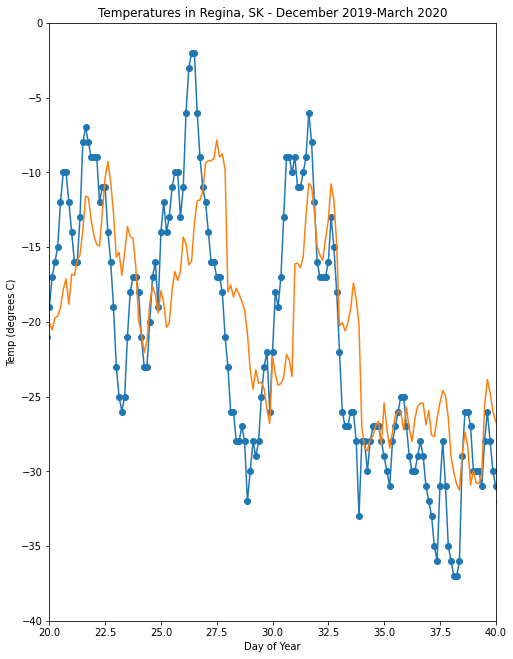

In [31]:
x = df['date_delta']

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,11))

axs.plot(df['date_delta'],df['tempC'],'o-')
axs.set_ylabel('Temp (degrees C)')
axs.set_xlabel('Day of Year')
axs.set_title('Temperatures in Regina, SK - December 2019-March 2020')
axs.plot(x,yfit)
axs.set_xlim(20,40)
axs.set_ylim(-40,0)
plt.show()

,date_time,maxtempC,mintempC,tempC,tempC_1,tempC_2,tempC_3,DewPointC_1,DewPointC_2,DewPointC_3,...,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3,date,date_delta
24,2019-01-04 00:00:00,1,-10,-8,-5.0,-11.0,-28.0,-4.0,-8.0,-30.0,...,22.0,10.0,254.0,291.0,203.0,0.0,0.0,0.0,2019-01-04 00:00:00,3.000
25,2019-01-04 03:00:00,1,-10,-9,-5.0,-8.0,-28.0,-7.0,-9.0,-30.0,...,21.0,12.0,256.0,301.0,184.0,0.0,0.0,0.0,2019-01-04 03:00:00,3.125
26,2019-01-04 06:00:00,1,-10,-10,-6.0,-11.0,-27.0,-7.0,-12.0,-29.0,...,16.0,14.0,259.0,298.0,172.0,0.0,0.0,0.0,2019-01-04 06:00:00,3.250
27,2019-01-04 09:00:00,1,-10,-9,-5.0,-10.0,-24.0,-6.0,-11.0,-27.0,...,14.0,16.0,260.0,277.0,177.0,0.0,0.0,0.0,2019-01-04 09:00:00,3.375
28,2019-01-04 12:00:00,1,-10,-2,-2.0,-5.0,-18.0,-3.0,-7.0,-22.0,...,15.0,18.0,261.0,259.0,192.0,0.0,0.0,0.0,2019-01-04 12:00:00,3.500


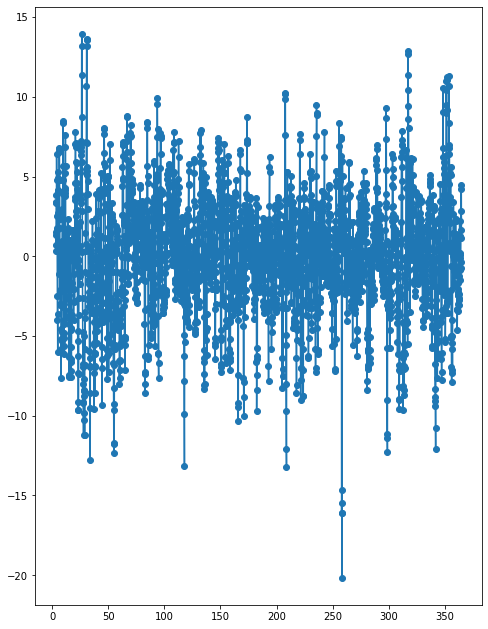

In [27]:
fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(8,11)) 

axs2.plot(df['date_delta'],df['tempC']-yfit,'o-')

df.head()

2.571301060347324e-15 3.7971184121102524


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Legend does not support 'Fit' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Legend does not support 'Data' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


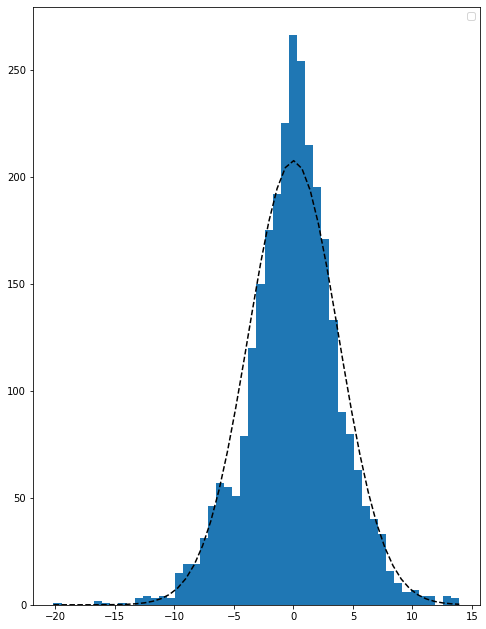

In [32]:
# best fit of data
data = df['tempC']-yfit
(mu, sigma) = stats.norm.fit(data)
print (mu,sigma)

# Empirical average and variance are computed
nbins = 50
avg = mu
var = sigma**2
N = len(df)
# From that, we know the shape of the fitted Gaussian.
pdf_x = np.linspace(np.min(data),np.max(data),nbins)
bin_size = (np.max(data) - np.min(data))/nbins
pdf_y = N*bin_size/np.sqrt(2*np.pi*var)*np.exp(-0.5*(pdf_x-avg)**2/var)

plt.hist(data,bins=nbins)
plt.plot(pdf_x,pdf_y,'k--')
plt.legend(("Fit","Data"),"best")
plt.show()